# CSI HAR
- LSTM & Attention
- Training:Validating:Testing = 6:2:2


## 1. Import libraries and dataset

In [2]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from numpy import dstack

# Data Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib.pyplot import figure

print('libraries have imported ')

libraries have imported 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/final_project/Experiment3/Data"
os.chdir(path)
results = pd.DataFrame([])
list_file = glob.glob("*.csv") #lisiting all the csv files
print(list_file)

['Lying_Amp_104.csv', 'Lying_Amp_209.csv', 'Empty_Amp_197.csv', 'Lying_Amp_121.csv', 'Empty_Amp_172.csv', 'Lying_Amp_204.csv', 'Lying_Amp_17.csv', 'Lying_Amp_110.csv', 'Empty_Amp_185.csv', 'Empty_Amp_32.csv', 'Lying_Amp_123.csv', 'Lying_Amp_162.csv', 'Lying_Amp_128.csv', 'Empty_Amp_182.csv', 'Empty_Amp_254.csv', 'Empty_Amp_65.csv', 'Empty_Amp_38.csv', 'Empty_Amp_250.csv', 'Lying_Amp_201.csv', 'Empty_Amp_211.csv', 'Lying_Amp_153.csv', 'Empty_Amp_266.csv', 'Lying_Amp_174.csv', 'Lying_Amp_197.csv', 'Lying_Amp_173.csv', 'Lying_Amp_208.csv', 'Lying_Amp_179.csv', 'Lying_Amp_186.csv', 'Empty_Amp_54.csv', 'Empty_Amp_25.csv', 'Lying_Amp_184.csv', 'Lying_Amp_119.csv', 'Lying_Amp_124.csv', 'Empty_Amp_37.csv', 'Empty_Amp_239.csv', 'Lying_Amp_127.csv', 'Empty_Amp_263.csv', 'Lying_Amp_106.csv', 'Empty_Amp_221.csv', 'Empty_Amp_61.csv', 'Empty_Amp_85.csv', 'Lying_Amp_166.csv', 'Empty_Amp_189.csv', 'Empty_Amp_92.csv', 'Empty_Amp_215.csv', 'Empty_Amp_170.csv', 'Empty_Amp_2.csv', 'Empty_Amp_28.csv', 'Emp

## 2. Preprocessing

In [5]:
# function for reading CSV files
def reading_file(activity_csv):
    results = []
    for i in range(len(activity_csv)):
        df = pd.read_csv(activity_csv[i])
        results.append(df.values)
    return results

In [6]:
#Classify each csv files by its activity
empty_csv = [i for i in list_file if i.startswith('Empty')]
lying_csv = [i for i in list_file if i.startswith('Lying')]
sitting_csv = [i for i in list_file if i.startswith('Sitting')]
standing_csv = [i for i in list_file if i.startswith('Standing')]
walking_csv = [i for i in list_file if i.startswith('Walking')]

In [7]:
#calling reading_file function
empty = reading_file(empty_csv)
lying = reading_file(lying_csv)
sitting = reading_file(sitting_csv)
standing = reading_file(standing_csv)
walking = reading_file(walking_csv)

### Labelling

In [8]:
#function for labeling the samples
def label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    return np.array(list_y).reshape(-1, 1)

In [9]:
walking_label = label(walking, 'walking')
empty_label = label(empty, 'empty')
lying_label = label(lying, 'lying')
sitting_label = label(sitting, 'sitting')
standing_label = label(standing, 'standing')

In [10]:
#concatenate all the samples into one np array
array_tuple = (empty, lying, sitting,standing, walking)
data_X = np.vstack(array_tuple)

#concatenate all the label into one array
label_tuple = (empty_label, lying_label, sitting_label,standing_label,  walking_label)
data_y = np.vstack(label_tuple)

#randomise the sample
from sklearn.utils import shuffle
data_X, data_y= shuffle(data_X, data_y)

### Splitting

Training, Validating, and Testing

In [18]:
from sklearn.model_selection import train_test_split
X = data_X
y = data_y

# split the data into training + validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split the training + validation set into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

### Standardisation

In [19]:
# Standardisation is necessary when using neural network

class Standard_Scaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [20]:
sc = Standard_Scaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform (X_val)
X_test = sc.transform (X_test)

### OneHotEncoder

In [25]:
#Encode categorical features (Activity Names) as a one-hot numeric array.
from sklearn.preprocessing import OneHotEncoder

en = OneHotEncoder()
y_train_en = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_en = OneHotEncoder().fit_transform(y_val.reshape(-1, 1)).toarray()
y_test_en = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

In [27]:
(X_train.shape, X_val.shape, X_test.shape, y_train_en.shape, y_val_en.shape, y_test_en.shape)

((720, 500, 256),
 (240, 500, 256),
 (241, 500, 256),
 (720, 5),
 (240, 5),
 (241, 5))

## 3. LSTM & Attention

In [37]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [39]:
class LSTMWithAttention(tf.keras.Model):
    def __init__(self, lstm_units, dense_units, num_classes):
        super(LSTMWithAttention, self).__init__()
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True, input_shape= X_train[-2,:].shape)
        self.attention = tf.keras.layers.Attention()
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.dense = tf.keras.layers.Dense(units=dense_units, activation='relu')
        self.final_dense = tf.keras.layers.Dense(units=num_classes, activation='softmax')

    def call(self, inputs):
        lstm_out = self.lstm(inputs)
        attention_out = self.attention([lstm_out, lstm_out])
        combined_out = self.flatten(attention_out)
        dropout_out = self.dropout(combined_out)
        dense_out = self.dense(dropout_out)
        return self.final_dense(dense_out)

In [40]:
# Create an instance of the model
activity_model = LSTMWithAttention(lstm_units=64, dense_units=32, num_classes=y_train_en.shape[1])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
opt = keras.optimizers.Adam(learning_rate=1e-8)

# Compile the model
activity_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
activity_model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
activity_model.summary()

Model: "lstm_with_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               multiple                  82176     
                                                                 
 attention_2 (Attention)     multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  1024032   
                                                                 
 dense_13 (Dense)            multiple                  165       
                                                                 
Total params: 1106373 (4.22 MB)
Trainable param

In [42]:
model_history = activity_model.fit(X_train, y_train_en, epochs= 100, validation_data=(X_val, y_val_en),  batch_size=32, callbacks = [lr_schedule])

Epoch 1/100
23/23 [==============================] - 7s 290ms/step - loss: 1.6107 - accuracy: 0.2125 - val_loss: 1.5387 - val_accuracy: 0.2625 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 7s 286ms/step - loss: 1.5928 - accuracy: 0.2250 - val_loss: 1.5381 - val_accuracy: 0.2625 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 7s 288ms/step - loss: 1.5849 - accuracy: 0.2528 - val_loss: 1.5375 - val_accuracy: 0.2625 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 6s 284ms/step - loss: 1.5951 - accuracy: 0.2347 - val_loss: 1.5368 - val_accuracy: 0.2625 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 7s 290ms/step - loss: 1.5805 - accuracy: 0.2167 - val_loss: 1.5360 - val_accuracy: 0.2667 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 6s 279ms/step - loss: 1.5862 - accuracy: 0.2292 - val_loss: 1.5351 - val_accuracy: 0.2708 - lr: 1.7783e-08
Epoch 7/100
23/23 [=====================

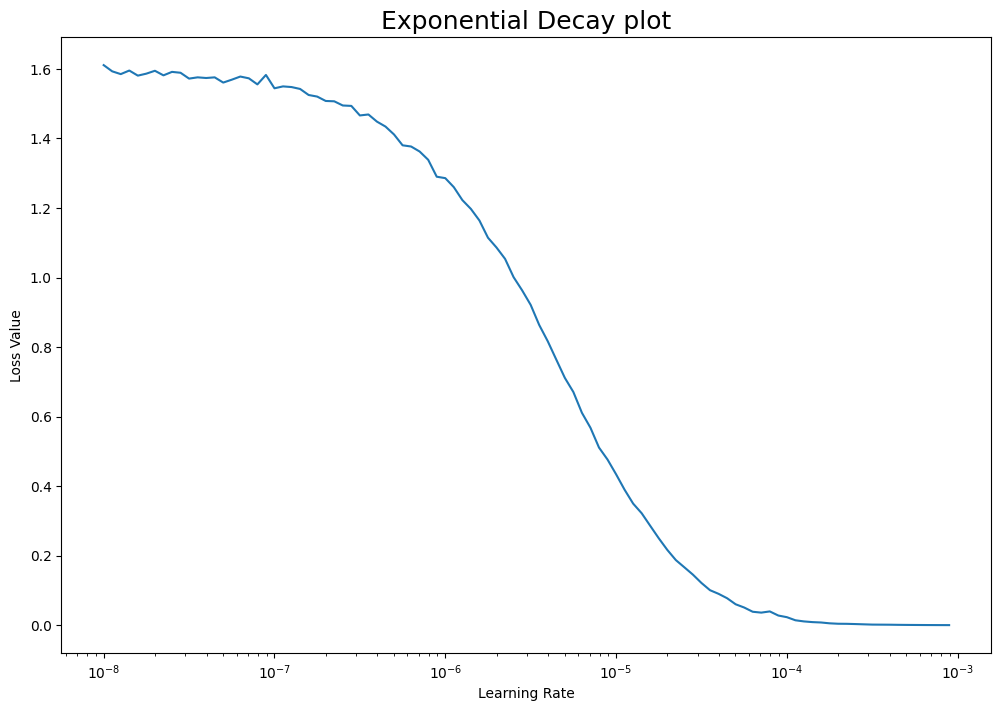

In [44]:
# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

### Model traing after choosing best learning rate

In [70]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = LSTMWithAttention(lstm_units=64, dense_units=32, num_classes=y_train_en.shape[1])

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

## Model Summary Plot

In [71]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## 4. LSTM Model Training

In [72]:
history = model.fit(X_train, y_train_en, epochs= 100, batch_size=16, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/100
36/36 [==============================] - 9s 198ms/step - loss: 0.5330 - accuracy: 0.8299 - val_loss: 0.2207 - val_accuracy: 0.9444
Epoch 2/100
36/36 [==============================] - 6s 168ms/step - loss: 0.0764 - accuracy: 0.9740 - val_loss: 0.1685 - val_accuracy: 0.9444
Epoch 3/100
36/36 [==============================] - 6s 177ms/step - loss: 0.0290 - accuracy: 0.9896 - val_loss: 0.0780 - val_accuracy: 0.9722
Epoch 4/100
36/36 [==============================] - 6s 167ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9792
Epoch 5/100
36/36 [==============================] - ETA: 0s - loss: 6.3190e-04 - accuracy: 1.0000
Accuracy has reached to threshold (98%) so stopping training!
36/36 [==============================] - 6s 179ms/step - loss: 6.3190e-04 - accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 0.9861


## 5. Model Evaluation

In [73]:
y_pred = model.predict(X_test) #prediction on test data set

model.evaluate(X_test, y_test_en)

8/8 [==============================] - 1s 92ms/step - loss: 0.0930 - accuracy: 0.9959


[0.0930228903889656, 0.9958506226539612]

# III. Result

# Model History plot

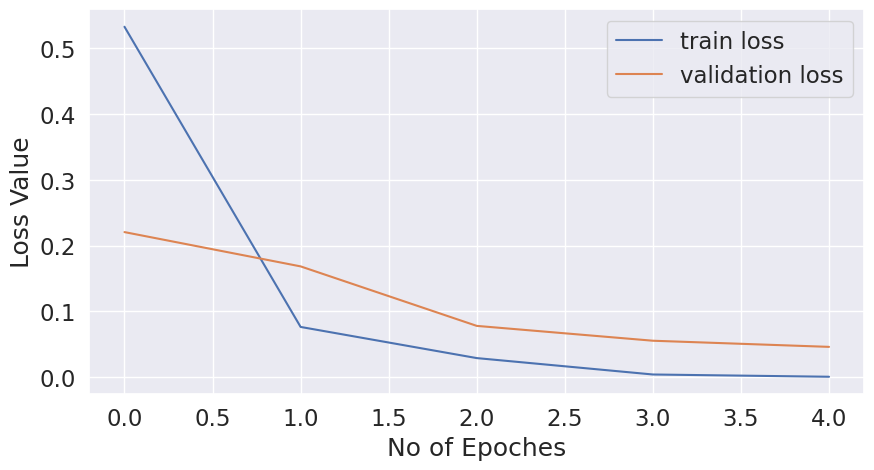

In [79]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

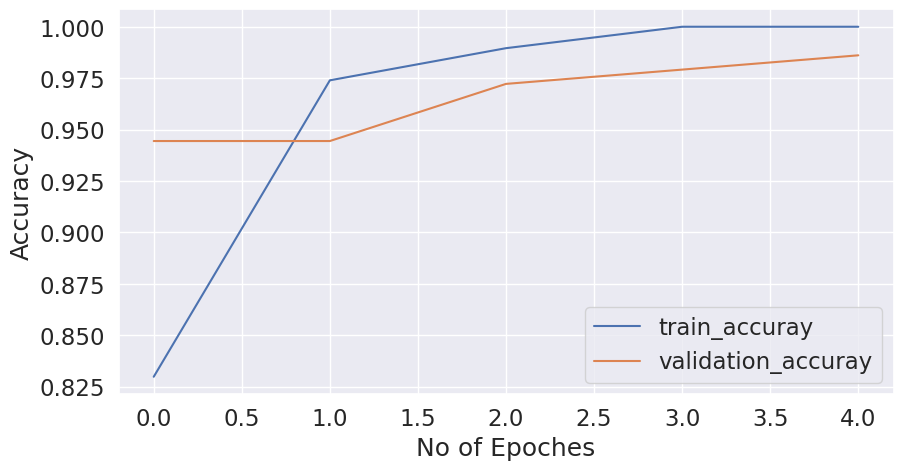

In [80]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuray')
plt.plot(history.history['val_accuracy'], label='validation_accuray')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

# Confusion Matrix

In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'Lying', 'Sitting','Standing','Walking']
columns = ['Empty', 'Lying', 'Sitting','Standing','Walking']
df_cm = pd.DataFrame(confusion_matrix,columns,index)

Text(0.5, 13.249999999999995, 'Predicted Activities')

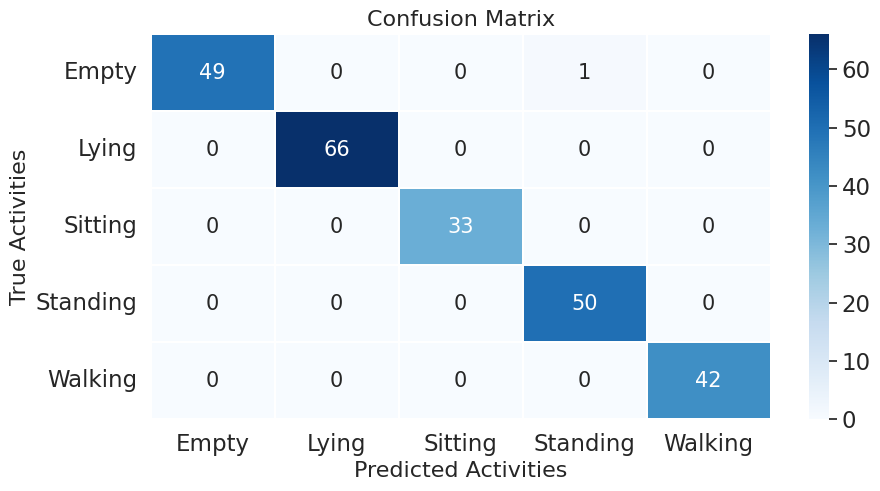

In [82]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [83]:
# Classification Report
from sklearn.metrics import classification_report
target_names = ['Empty', 'Lying', 'Sitting','Standing','Walking']
print(classification_report(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

       Empty       1.00      0.98      0.99        50
       Lying       1.00      1.00      1.00        66
     Sitting       1.00      1.00      1.00        33
    Standing       0.98      1.00      0.99        50
     Walking       1.00      1.00      1.00        42

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

